In [113]:
from astropy.io import fits
#fits_image_filename = astropy.io.fits.open('../C1_lc.fits')
import scipy.optimize as op

with fits.open('../../C1_lc.fits') as hdul:
    print(hdul[1].columns)
    print(hdul[1].data.shape[0])
    max_rows = hdul[1].data.shape[0]

ColDefs(
    name = 'COADD_OBJECT_ID'; format = 'J'
    name = 'RA'; format = 'E'
    name = 'DEC'; format = 'E'
    name = 'MAGERR_AUTO_G'; format = 'E'
    name = 'MAGERR_AUTO_R'; format = 'E'
    name = 'MAGERR_AUTO_I'; format = 'E'
    name = 'MAGERR_AUTO_Z'; format = 'E'
    name = 'MAGERR_AUTO_Y'; format = 'E'
    name = 'MAGERR_DETMODEL_G'; format = 'E'
    name = 'MAGERR_DETMODEL_R'; format = 'E'
    name = 'MAGERR_DETMODEL_I'; format = 'E'
    name = 'MAGERR_DETMODEL_Z'; format = 'E'
    name = 'MAGERR_DETMODEL_Y'; format = 'E'
    name = 'MAG_AUTO_G'; format = 'E'
    name = 'MAG_AUTO_R'; format = 'E'
    name = 'MAG_AUTO_I'; format = 'E'
    name = 'MAG_AUTO_Z'; format = 'E'
    name = 'MAG_AUTO_Y'; format = 'E'
    name = 'MAG_DETMODEL_G'; format = 'E'
    name = 'MAG_DETMODEL_R'; format = 'E'
    name = 'MAG_DETMODEL_I'; format = 'E'
    name = 'MAG_DETMODEL_Z'; format = 'E'
    name = 'MAG_DETMODEL_Y'; format = 'E'
    name = 'SPREAD_MODEL_G'; format = 'E'
    name = 'SPR

79410


In [65]:
%matplotlib inline 
import astropy.io.fits as pyfit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import stats

FITS = pyfit.open(r'../../C1_lc.fits')

def get_vals(args, ROW):
    color_dict = {"g": 1, "r": 2, "i": 3, "z": 4}
    lc_median = {}
    time = np.array([])
    flux_norm = np.array([])
    err_norm = np.array([])
    array_org = np.array([])
    #fig = plt.figure(figsize=(12, 6))
    #ax5 = fig.add_subplot(111)
    color_plt = iter(cm.rainbow(np.linspace(0, 1, 5)))
    a_b_list = read_a_b_chi2()
    #print(a_b_list)
    for color in "griz":
        FITS = pyfit.open(args)
        # Obtain flux, err, and time arrays
        try:
            lc_flux = FITS[1].data['LC_FLUX_PSF_'+color][ROW]
        except IndexError:
            print('Error')
            exit()

        lc_time = FITS[1].data['LC_MJD_'+color][ROW]
        limit = len(lc_time[lc_time != 0])
        lc_median[color] = FITS[1].data['MEDIAN_PSF_'+color][ROW] #change back to median
        if limit < 3:
            lc_median[color] = 0.0
            #print("Not enough " + color + " observations!")
            continue

        time = np.append(time, lc_time[lc_time != 0.])  # remove the zeros
        lc_flux_err = FITS[1].data['LC_FLUXERR_PSF_'+color][ROW]

        array_org = np.append(array_org, color_dict[color]*np.ones(limit))
        lc_flux = lc_flux[:limit]
        lc_flux_err = lc_flux_err[:limit]
        col = next(color_plt)

        mean_err = FITS[1].data['MEANERR_PSF_'+color][ROW]
        a, b = get_a_b_chi2(args, color, a_b_list)
        #print(a, b)
        #print("OG ERR "+color)
        #print(lc_flux_err)

        flux_err_corr = np.sqrt(np.abs((a**2)*lc_flux*np.sqrt(np.abs(lc_flux_err**2 - mean_err**2)) + (b**2)*(lc_flux_err**2 - mean_err**2)))
        #print("AB CORR ERR "+color)
        #print(flux_err_corr)

        #ax5.scatter(lc_time[lc_time != 0],
        #            (lc_flux[0:limit] - lc_median[color])/lc_median[color],
        #            label=color, c=np.array([col]))
        #ax5.legend()
        #ax5.set_title("Pre-correction light curve: Row "+ str(ROW))
        #ax5.set_ylabel("Median-corrected Flux")
        #ax5.set_xlabel("time [MJD]")
        normed_flux = (lc_flux - lc_median[color])/lc_median[color]

        flux_norm = np.append(flux_norm, normed_flux)
        normed_err = flux_err_corr/lc_median[color] #lc_flux_err/lc_median[color] #
        err_norm = np.append(err_norm, normed_err)
    time, flux_norm, err_norm, array_org = map(list,
                                               zip(*sorted(zip(time,
                                                               flux_norm,
                                                               err_norm,
                                                               array_org))))
    return flux_norm, err_norm, time, lc_median, array_org, FITS

def read_a_b_chi2():
    # must have a_b_calc.txt for this to work
    # a_b_calc.txt is made with the following command:
    # python chi_squared_LCs_all_band_data.py > a_b_calc.txt
    a_b_vals = []
    with open("a_b_calc.txt","r") as infile:
        for line in infile:
            #print(line)
            line = line.split('\n')[0]

            field, col, a, b = line.strip('()').split(',')

            a_b_vals.append((field.replace("'", "").strip(), col.replace("'", "").strip(), float(a), float(b)))
    return a_b_vals


def get_a_b_chi2(fit, color, a_b_vals):
    #print(a_b_vals)
    field_name = fit.split("/")[-1].split("_")[0]
    for item in a_b_vals:
        if item[0] == field_name and item[1] == color.upper():
            a, b = item[2], item[3]
            #print(item)
    return a, b

def lin_color_sort(time, color_sort_dict, color_sort):
    int_time = time.astype(int)
    flux_dict = {"g": [], "r": 0, "i": [], "z": []}
    g_flux = []
    i_flux = []
    z_flux = []
    prev_time = int_time[0]
    for i in range(0, len(int_time)):
        if abs(int_time[i] - prev_time) <= 1:
            if color_sort_dict[color_sort[i]] == 'r':
                flux_dict["r"] = flux[i]
            else:
                flux_dict[color_sort_dict[color_sort[i]]].append(flux[i])
        else:
            # record results
            if flux_dict["r"] != 0:
                f_r = flux_dict["r"]
                if len(flux_dict["g"]) != 0:
                    for f_g in flux_dict["g"]:
                        g_flux.append([f_r, f_g])
                if len(flux_dict["i"]) != 0:
                    for f_i in flux_dict["i"]:
                        i_flux.append([f_r, f_i])
                if len(flux_dict["z"]) != 0:
                    for f_z in flux_dict["z"]:
                        z_flux.append([f_r, f_z])
            # start new count
            flux_dict = {"g": [], "r": 0, "i": [], "z": []}
            prev_time = int_time[i]
            if color_sort_dict[color_sort[i]] == 'r':
                flux_dict["r"] = flux[i]
            else:
                flux_dict[color_sort_dict[color_sort[i]]].append(flux[i])
    return g_flux, i_flux, z_flux


In [61]:
flux, err, time, mu, color_sort, FITS = get_vals(r'../../C1_lc.fits', 0)

In [53]:
flux, err, time, mu, color_sort,  FITS = get_vals(r'/home/sam/Documents/Morganson_research/C1_lc.fits', 8)

0.07039081567272482 1.1266227863751934
0.05221471667461246 1.056666068277515
0.04806290106492023 1.0455954114090282
0.0339112340056333 1.0616862096323512


0.07039081567272482 1.1266227863751934
0.05221471667461246 1.056666068277515
0.04806290106492023 1.0455954114090282
0.0339112340056333 1.0616862096323512


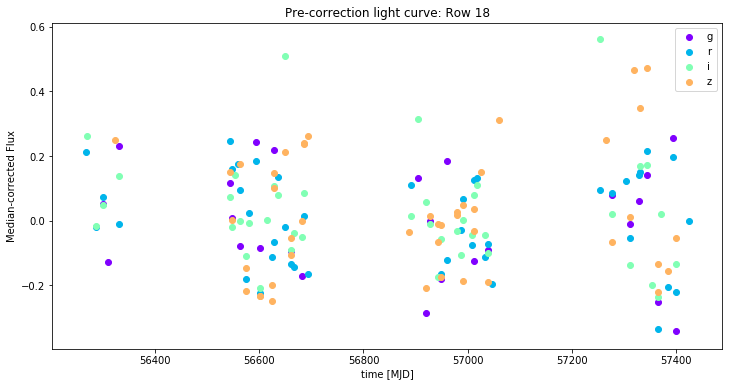

In [31]:
flux, err, time, mu, color_sort,  FITS = get_vals(r'/home/sam/Documents/Morganson_research/C1_lc.fits', 18)

0.07039081567272482 1.1266227863751934
0.05221471667461246 1.056666068277515
0.04806290106492023 1.0455954114090282
0.0339112340056333 1.0616862096323512


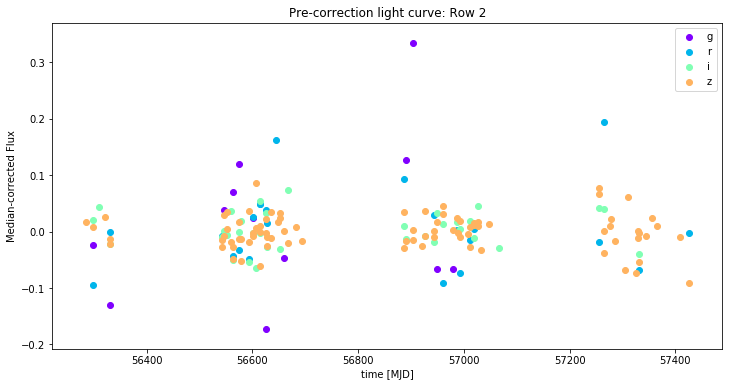

In [32]:
flux, err, time, mu, color_sort,  FITS = get_vals(r'/home/sam/Documents/Morganson_research/C1_lc.fits', 2)

Not enough g observations!
0.05221471667461246 1.056666068277515
0.04806290106492023 1.0455954114090282
0.0339112340056333 1.0616862096323512


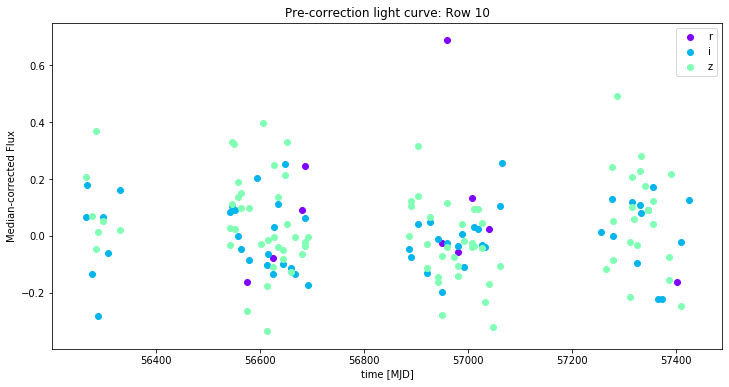

In [33]:
flux, err, time, mu, color_sort,  FITS = get_vals(r'/home/sam/Documents/Morganson_research/C1_lc.fits', 10)

0.07039081567272482 1.1266227863751934
0.05221471667461246 1.056666068277515
0.04806290106492023 1.0455954114090282
0.0339112340056333 1.0616862096323512
174


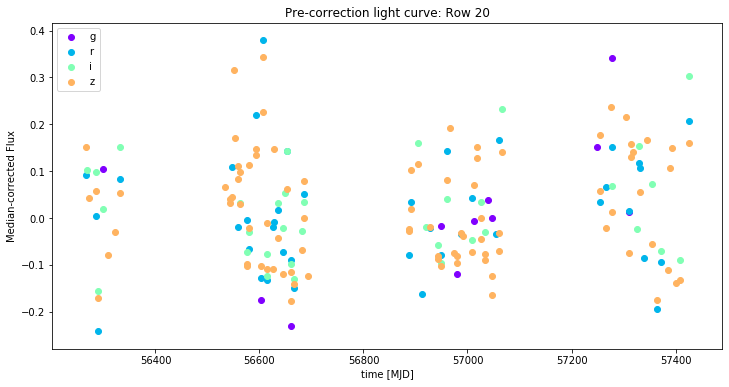

In [35]:
flux, err, time, mu, color_sort,  FITS = get_vals(r'/home/sam/Documents/Morganson_research/C1_lc.fits', 20)
print(len(np.isnan(flux)==True))

In [54]:
def plot_lin(flux, ax, y_label):
    if flux and len(flux) > 2:
        flux = np.array(flux)

        def linear(x, a, b):
            return a * x + b

        p, res = op.curve_fit(linear, flux[:, 0], flux[:, 1] - flux[:, 0])

        #ax.scatter(flux[:, 0], flux[:, 1] - flux[:, 0])
        #ax.plot(flux[:, 0], flux[:, 0]*p[0] + p[1], label="{0:.3f}x + {1:.3f}".format(*p))
    else:
        p = (0, 0)
        res = np.zeros((2, 2))

    #ax.legend()
    #ax.set_xlabel('r')
    #ax.set_ylabel(y_label)

    return p, res

In [94]:
#VARIABILITY CHI2 & STD SCATTER PLOTS

Fits_file = r'../../C1_lc.fits'
var_strict = 3
var_chi = []
var_std = []
non_var_chi = []
non_var_std = []

for ROW in range(0, int(max_rows/5)):
    if ROW%100 == 0:
        print("Running object "+str(ROW))
    #fig = plt.figure(figsize=(10, 10))
    flux, err, time, mu, color_sort, FITS = get_vals(Fits_file, ROW)
    #print(min(np.array(time[1:]) - np.array(time[:-1])))

    # DOESN'T MAKE SENSE TO LOOK AT ROWS WITH NO FLUX MEASUREMENTS
    if len(flux) == 0:
        print("Flux length is zero")
        continue

    # ONLY LET POSITIVE FLUXES AND ERRORS THROUGH
    # NOTE: FLUXES HERE ARE NORMALIZED, SO IF FLUX = 0, THEN norm(FLUX) = -1
    zip_tfe = zip(time, flux, err, color_sort)
    filter_tfe = [(t, f, e, col) for t, f, e, col in zip_tfe if f > -1 and e > 0]
    time, flux, err, color_sort = zip(*filter_tfe)
    time = np.array(time)
    flux = np.array(flux)
    err = np.array(err)
    color_sort = np.array(color_sort)
    unique, count = np.unique(color_sort, return_counts=True)
    color_sort_dict = {1: "g", 2: "r", 3: "i", 4: "z"}
    color_counts = dict(zip([color_sort_dict[u] for u in unique], count))
        
    #print("Counts: " + str(color_counts))

    # ONLY LOOK AT BRIGHT OBJECTS (WITHOUT OVERSATURATION)
    dim = [i for i in mu if 22.5-2.5*np.log10(mu[i])>23]
    dim_val = [22.5-2.5*np.log10(mu[i]) for i in mu if 22.5-2.5*np.log10(mu[i])>23]
    bright = [i for i in mu if 22.5-2.5*np.log10(mu[i])<16]
    bright_val = [22.5-2.5*np.log10(mu[i]) for i in mu if 22.5-2.5*np.log10(mu[i])<16]
    spread = [i for i in "GRIZ" if np.abs(FITS[1].data['SPREAD_MODEL_'+i][ROW]) > .003]
    #if dim:
        #print("Row is too dim in band: "+ str(dim)+str(ROW))
        #print(dim_val)
    #    plt.close("all")
    #    continue
    #if bright:
        #print("Row is HELLA bright in band: "+str(bright)+str(ROW))
        #print(bright_val)
    #    plt.close("all")
    #    continue
    if spread:
        #print("Too spread out in band: "+str(spread)+str(ROW))
        continue
    print(str(ROW)+ " is good")

    #print("Mu: " + str(mu))

    color_sort_ones = [(color_sort == 1).astype(int)]
    for num in range(2, 5):
        color_sort_ones = np.concatenate((color_sort_ones, [(color_sort == num).astype(int)]), axis=0)
    np.set_printoptions(threshold=np.inf)

    g_flux, i_flux, z_flux = lin_color_sort(time, color_sort_dict, color_sort)

    #fig_lin, axs = plt.subplots(3)
    #fig_lin.suptitle('r vs color')


    p_g, res_g = plot_lin(g_flux, axs[0], "g-r")
    p_i, res_i = plot_lin(i_flux, axs[1], "i-r")
    p_z, res_z = plot_lin(z_flux, axs[2], "z-r")

    slope = [p_g[0]+1, 1, p_i[0]+1, p_z[0]+1]
    slope_err = [np.sqrt(res_g[0][0]), 0, np.sqrt(res_i[0][0]), np.sqrt(res_z[0][0])]
    int_err = [np.sqrt(res_g[1][1]), 0, np.sqrt(res_i[1][1]), np.sqrt(res_z[1][1])]
    std_col = []
    mean_err = []
    color_dict = {0:"g", 1:"r", 2:"i", 3:"z"}
    for col in 'GRIZ':
        std_col.append(FITS[1].data['STD_PSF_'+col][ROW])
        mean_err.append(FITS[1].data['MEANERR_PSF_'+col][ROW])
    intercept = [p_g[1], 0, p_i[1], p_z[1]]
    var_count = 0
    var_bands = ""
    
    for i in range(len(slope)):
        if np.count_nonzero(color_sort_ones[i]) > 1:
            var_crit = mean_err[i]*np.sqrt(np.count_nonzero(color_sort_ones[i]))
            fl = flux*mu[color_dict[i]]
            errors = err*mu[color_dict[i]]
            fl = fl[color_sort_ones[i] != 0. ]
            errors = errors[color_sort_ones[i] != 0.]
            chi2 = np.sum((fl**2)/errors**2)/(np.count_nonzero(color_sort_ones[i])-1)
        else:
            var_crit = 0
            chi2 = 0
        #print("Variable??")
        #print(var_crit)
        #print(chi2)
        
        if chi2 > 100 and std_col[i] <0.2:
            print("Chi too high or std too low")
            continue
        
        if std_col[i]/var_crit > var_strict and chi2 > var_strict:
            #print("Variable Source!")
            var_chi.append(chi2)
            var_std.append(std_col[i]/mu[color_dict[i]]) #/var_crit)
        else:  # if nonvariable
            #print("Non-Variable source in " + str(color_sort_dict[i+1]))
            non_var_chi.append(chi2)
            non_var_std.append(std_col[i]/mu[color_dict[i]]) #/var_crit)
            


Running object 0
2 is good
3 is good
5 is good
6 is good
9 is good


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log10


19 is good
22 is good
32 is good
73 is good
76 is good
80 is good
86 is good
98 is good
Running object 100
104 is good
117 is good
126 is good
127 is good
135 is good
138 is good
149 is good
150 is good
158 is good
161 is good
165 is good
166 is good


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide
/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in true_divide


170 is good
184 is good
193 is good
Running object 200
205 is good
206 is good
207 is good
209 is good
220 is good
221 is good
241 is good
248 is good
262 is good
275 is good
284 is good
286 is good
293 is good
294 is good
Running object 300
312 is good
329 is good
341 is good
342 is good
363 is good
373 is good
374 is good
386 is good
391 is good
395 is good
398 is good
399 is good
Running object 400
406 is good
424 is good
428 is good
431 is good
437 is good
473 is good
479 is good
489 is good


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in true_divide
/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in true_divide


496 is good
Running object 500
509 is good
528 is good
530 is good
540 is good
544 is good
545 is good
554 is good
565 is good
566 is good
587 is good
591 is good
Running object 600
602 is good
613 is good
622 is good
624 is good
626 is good
637 is good
648 is good
667 is good
680 is good
Running object 700
707 is good
714 is good
726 is good
732 is good
734 is good
743 is good
749 is good
757 is good
764 is good
779 is good
793 is good
Running object 800
801 is good
810 is good
830 is good
835 is good
847 is good
853 is good
859 is good
862 is good
874 is good
877 is good
Running object 900
913 is good
942 is good
947 is good
967 is good
970 is good
971 is good
Running object 1000
1009 is good
1017 is good
1043 is good
1044 is good
1045 is good
1074 is good
Running object 1100
1105 is good
1121 is good
1143 is good
1159 is good
1161 is good
1162 is good
1165 is good
1170 is good
1173 is good
1177 is good
1184 is good
1186 is good
1189 is good
Running object 1200
1201 is good
1204 is g

Running object 6100
6131 is good
6155 is good
6165 is good
6167 is good
6173 is good
6193 is good
6195 is good
Running object 6200
6209 is good
6234 is good
6266 is good
6267 is good
6276 is good
6278 is good
Running object 6300
6304 is good
6324 is good
6340 is good
6344 is good
6357 is good
6364 is good
6365 is good
6370 is good
6372 is good
6375 is good
6383 is good
6388 is good
6389 is good
6396 is good
Running object 6400
6405 is good
6406 is good
6419 is good
6428 is good
6440 is good
6441 is good
6447 is good
6448 is good
6480 is good
6499 is good
Running object 6500
6507 is good
6508 is good
6515 is good
6545 is good
6550 is good
6551 is good
6552 is good
6598 is good
Running object 6600
6610 is good
6619 is good
6628 is good
6642 is good
6665 is good
Running object 6700
6724 is good
6738 is good
6752 is good
6753 is good
6756 is good
6773 is good
Running object 6800
6801 is good
6810 is good
6812 is good
6819 is good
6826 is good
6834 is good
6842 is good
6858 is good
6867 is 

12102 is good
12105 is good
12128 is good
12151 is good
12181 is good
12182 is good
Running object 12200
12205 is good
12206 is good
12262 is good
12271 is good
12274 is good
12275 is good
12286 is good
12293 is good
12295 is good
Running object 12300
12320 is good
12322 is good
12364 is good
12379 is good
12386 is good
Running object 12400


KeyboardInterrupt: 

188
4424


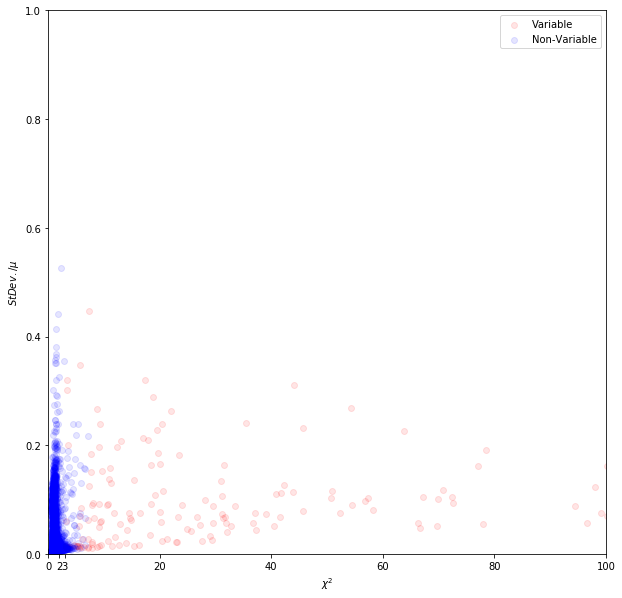

In [106]:
fig = plt.figure(figsize=(10, 10))            
ax6 = fig.add_subplot(111)      
ax6.scatter(var_chi, var_std, c='red', alpha=0.1, label="Variable")
print(len(var_chi))

ax6.scatter(non_var_chi, non_var_std, c='b', alpha=0.1, label="Non-Variable")
print(len(non_var_chi))
ax6.legend()

ax6.set_xlim(0,100)
ax6.set_ylim(0,1)
ax6.set_ylabel(r"$St Dev./ \mu$")
ax6.set_xlabel(r"$\chi^2$")
ax6.set_xticks([0, 2, 3, 20, 40, 60, 80, 100])
            
plt.show()

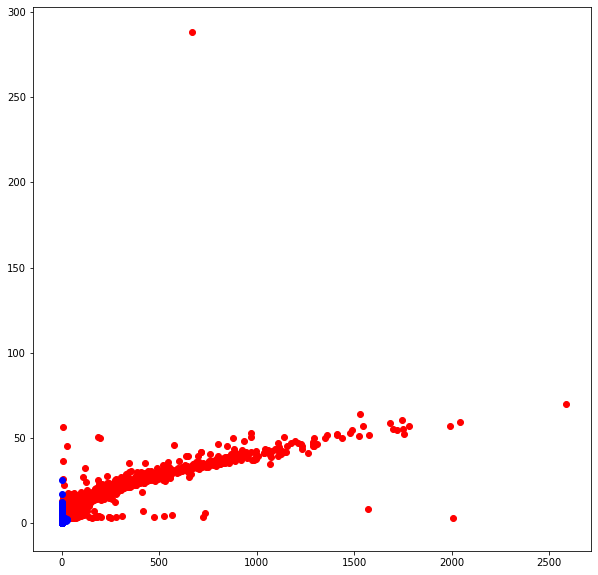

In [74]:
fig = plt.figure(figsize=(10, 10))            
ax6 = fig.add_subplot(111)      
var_chi.remove(max(var_chi))
var_std.remove(max(var_std))
ax6.scatter(var_chi, var_std, c='r')
ax6.scatter(non_var_chi, non_var_std, c='b')
            
plt.show()